In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.wrapper_wandb import wrapper_tools
from JPAS_DA.evaluation import evaluation_tools

import os
import torch
import numpy as np

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib inline

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

In [2]:
config_path = os.path.join(global_setup.path_configs, "config_direct.yaml")
run_name = "09_direct"

In [3]:
config_0, config, dset_train, dset_val, config_encoder, model_encoder, config_downstream, model_downstream, min_val_loss = wrapper_tools.wrapper_train_from_config(
    config_path, run_name
)

2025-09-26 16:29:45,543 - INFO - 🔍 Checking for config file at: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/configs/config_direct.yaml
2025-09-26 16:29:45,547 - INFO - ✅ Successfully loaded config file: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/configs/config_direct.yaml
2025-09-26 16:29:45,547 - INFO - N_threads: 1
2025-09-26 16:29:45,547 - INFO - 📦 Parsing configuration to prepare DataLoaders...
2025-09-26 16:29:45,547 - INFO - 📦 Loading datasets with load_data_bundle()
2025-09-26 16:29:45,547 - INFO - 📥 Starting modular dataset loading (load_data_bundle)
2025-09-26 16:29:45,548 - INFO - ├── Loading JPAS_x_DESI_Raul ...
2025-09-26 16:29:45,548 - INFO - ├─── 📥 Starting JPAS_x_DESI_Raul dataset loading...
2025-09-26 16:29:45,548 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-09-26 16:29:45,595 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-09-26 16:29:45,607 - INFO -

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/utils/plotting_utils.py:936: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


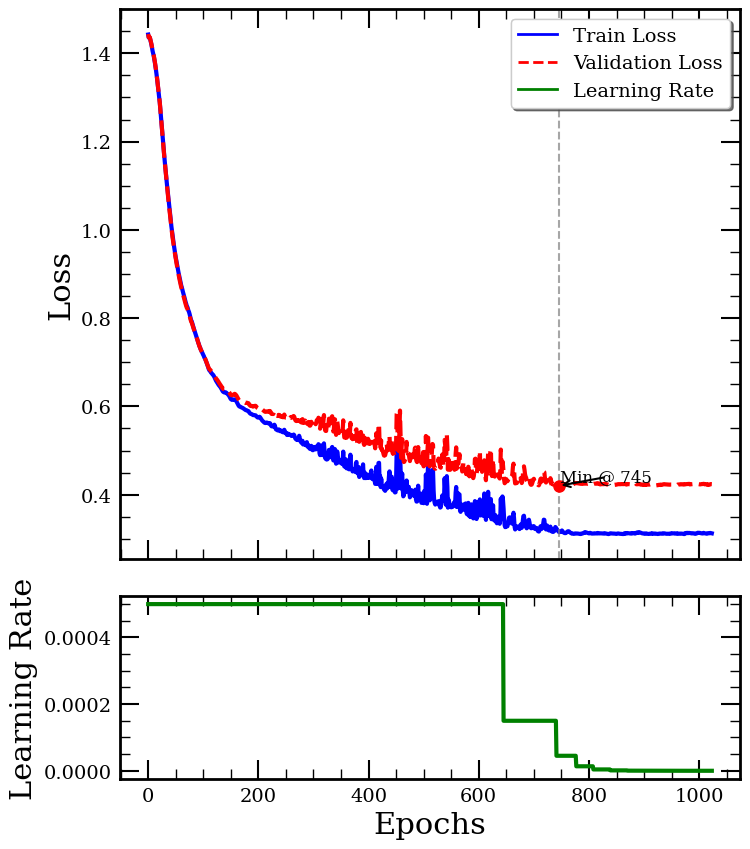

In [4]:
plotting_utils.plot_training_curves(config["training"]["path_save"])

In [5]:
device = next(model_encoder.parameters()).device

model_encoder.eval()
model_downstream.eval()

if len(dset_train.class_labels) == 2:
    class_names = ['QSO_high', 'no_QSO_high']
else:
    class_names = list(global_setup.config_dict_cleaning["encoding"]["shared_mappings"]["SPECTYPE"].keys())

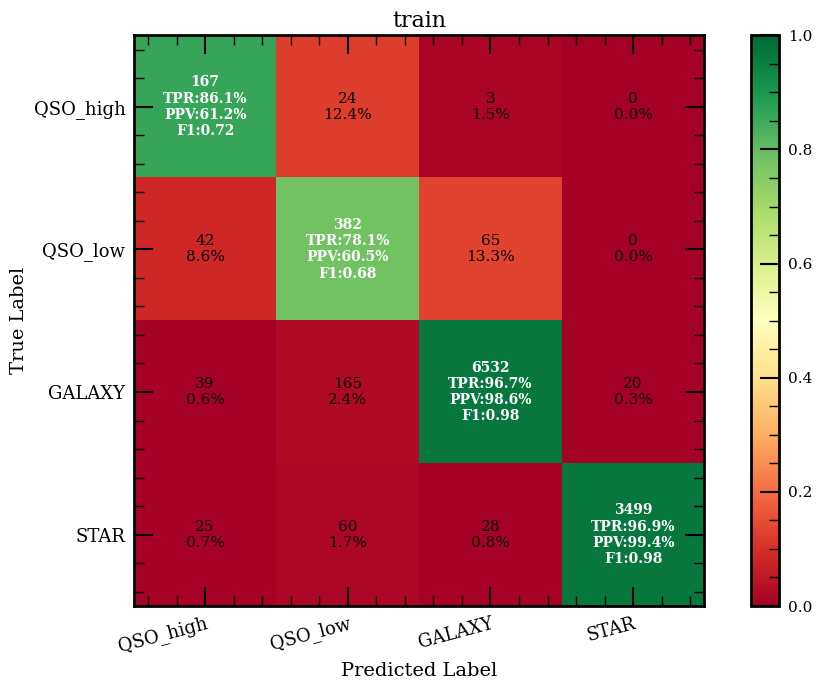

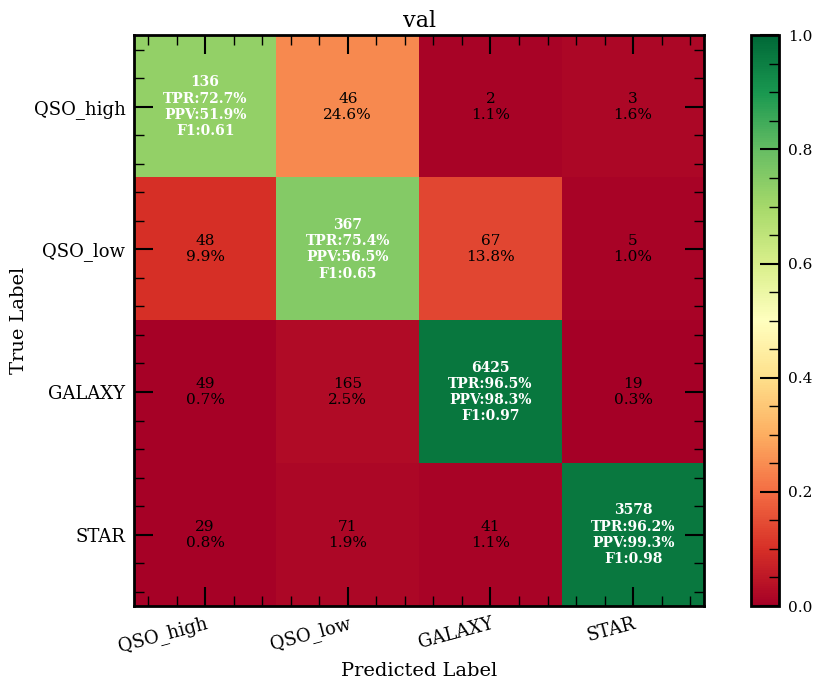

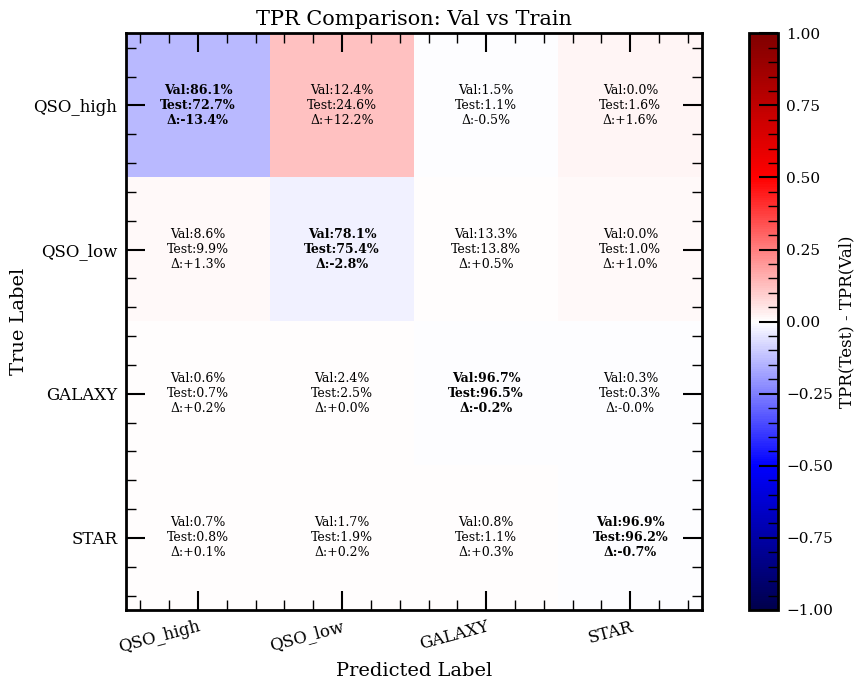


=== train vs val Metrics ===
Metric                               train         val   Δ (val - train)
------------------------------------------------------------------------
Accuracy                            0.9574      0.9507           -0.0067
Macro F1                            0.8387      0.8007           -0.0380
Macro TPR                           0.8944      0.8520           -0.0424
Macro Precision                     0.7992      0.7651           -0.0342
Macro AUROC                         0.9789      0.9581           -0.0207
Expected Calibration Error          0.0597      0.0529           -0.0068
Brier Score                         0.0808      0.0915            0.0108


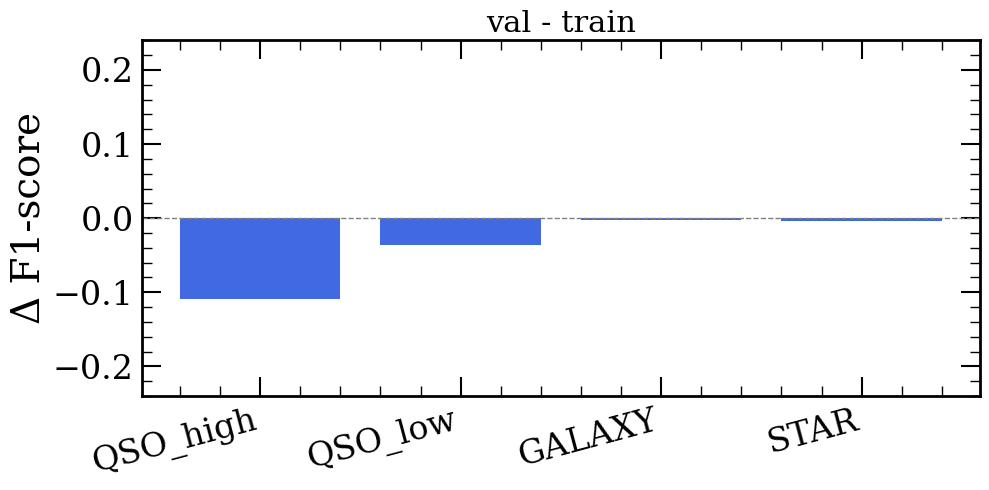

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/evaluation_tools.py:1200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


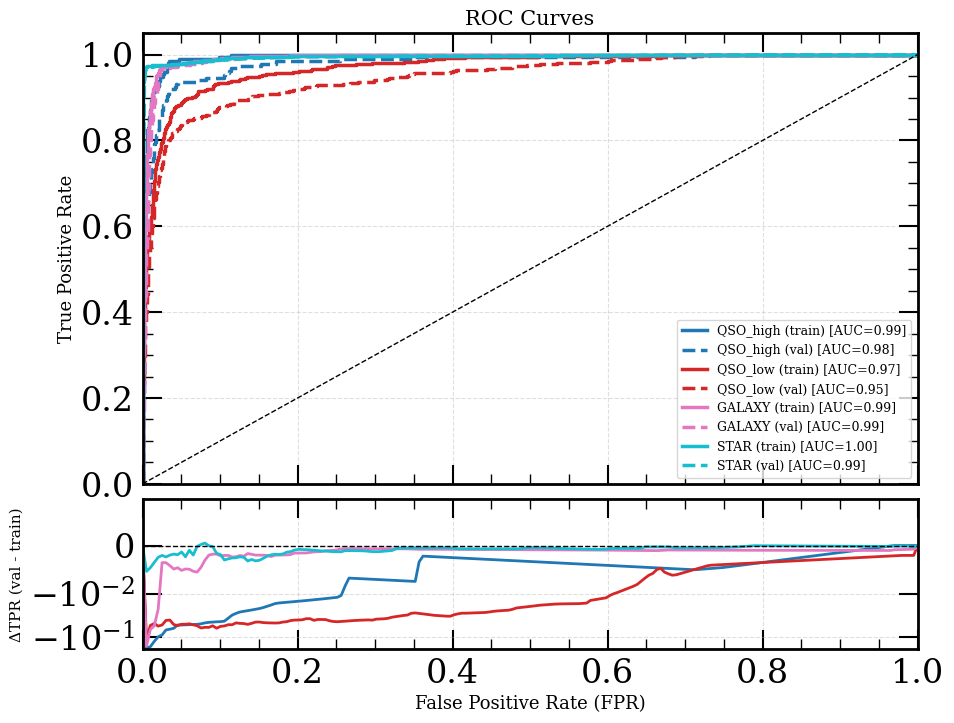

In [6]:
# === Train ===
xx_train, yy_true_train = dset_train(batch_size=dset_train.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_train = model_encoder(xx_train)
        logits = model_downstream(features_train)
yy_pred_P_train = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_train = yy_pred_P_train.cpu().numpy()
yy_pred_train = np.argmax(yy_pred_P_train, axis=1)
yy_true_train = yy_true_train.cpu().numpy()
xx_train = xx_train.cpu().numpy()
features_train = features_train.cpu().numpy()

evaluation_tools.plot_confusion_matrix(
    yy_true_train, yy_pred_P_train,
    class_names=class_names,
    cmap=plt.cm.RdYlGn, title="train"
)


# === Val ===
xx_val, yy_true_val = dset_val(batch_size=dset_val.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device=device)

with torch.no_grad():
        features_val = model_encoder(xx_val)
        logits = model_downstream(features_val)
yy_pred_P_val = torch.nn.functional.softmax(logits, dim=1)
yy_pred_P_val = yy_pred_P_val.cpu().numpy()
yy_pred_val = np.argmax(yy_pred_P_val, axis=1)
yy_true_val = yy_true_val.cpu().numpy()
xx_val = xx_val.cpu().numpy()
features_val = features_val.cpu().numpy()

evaluation_tools.plot_confusion_matrix(
    yy_true_val, yy_pred_P_val,
    class_names=class_names,
    cmap=plt.cm.RdYlGn, title="val"
)


# === Compare Train VS Val ===
evaluation_tools.compare_TPR_confusion_matrices(
    yy_true_train,
    yy_pred_P_train,
    yy_true_val,
    yy_pred_P_val,
    class_names=class_names,
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: Val vs Train'
)

metrics = evaluation_tools.compare_sets_performance(
    yy_true_train, yy_pred_P_train,
    yy_true_val, yy_pred_P_val,
    class_names=class_names,
    name_1="train",
    name_2="val"
)